In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import theano
floatX = theano.config.floatX
import theano.tensor as T
import pymc3 as pm

import matplotlib.pyplot as plt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Classify Fashion MNIST using Bayesian Neural Network Approach

## MA578 Bayesian Statistics Final Project
### Author: Zichun Liu

---------

# Introduction

In this notebook, I performed a Bayesian Neural Network to solve a classification problem. Given picture of different kinds of clothes, I trained a BNN to classify which category a certain picture belongs to.

The algorithm was performed by pymc3 and theano

The result shows that BNN approach could have a pretty good performance on classification problems.

---

## 1) Data

Fashion-MNIST is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example how the data looks (each class takes three-rows):

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. 

Fashion-MNIST dataset has been adopted by many popular Machine Learning framework. For example, mxnet have made Fashion-MNIST a built-in dataset for computer vision. I will directly get data from there:

In [3]:
from mxnet import gluon
def get_fashionMNIST(istrain = True):
    def transform(data, label):
        return data.astype('float32')/255, label.astype('float32') #normalize data
    mnist = gluon.data.vision.FashionMNIST(train=istrain, transform=transform)
    data, label = mnist[0:]
    data = data.asnumpy().reshape(-1,28*28)
    #label = pd.get_dummies(label).values.astype("float32")
    return data, label 

In [4]:
# a training set of 60,000 examples 
data_train, label_train = get_fashionMNIST(True)
#  a test set of 10,000 examples
data_test, label_test = get_fashionMNIST(False)

print(data_train.shape,data_test.shape)

In [5]:
#show some data point
import matplotlib.pyplot as plt
def show_image(image):
    plt.imshow(image.reshape(28,28))
    plt.show()

def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape(28, 28))
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()
    
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress,', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

def get_text_labels(label):
    #label = np.nonzero(label)[1]
    return [text_labels[int(i)] for i in label]


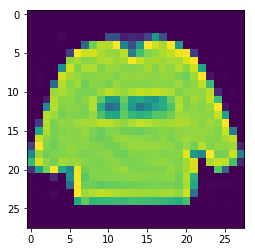

pullover


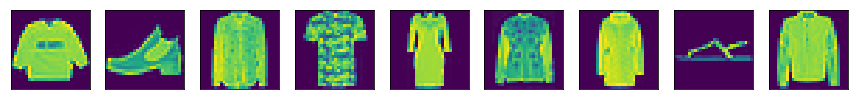

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress,', 'coat', 'coat', 'sandal', 'coat']


In [6]:
#single picture and its label
show_image(data_train[0])
#print(text_labels[int(np.nonzero(label_train)[1][0])])
print(text_labels[int(label_train[0])])

#a batch of pictures and their label
show_images(data_train[0:9])
print(get_text_labels(label_train[0:9]))

----
## 2) Model specification¶

The result of Bayesian modeling is the conditional probability distribution of unobserved variables
of interest, given the observed data. In Bayesian Neural Network the natural end variables are the predictions of the model for new inputs, while the posterior distribution of the network weights is rarely of much interest.(Jouko Lampinen, 2001)

The posterior predictive distribution of output $y^{new}$ for the new input $x^{new}$ given the training data $D =
\{(x^{(1)}, y^{(1)}), . . . , (x^{(n)}, y^{(n)})\}$, is obtained by integrating the predictions of the model with respect to the posterior distribution of the model:

$$
p(y^{new}|x^{new},D) = \int p(y^{new}|x^{new},\theta)p(\theta|D)d\theta
$$

where $\theta$ denotes all the model parameters and hyperparameters of the prior structures.

Based on Jouko, A convenient commonly used prior distribution is Gaussian, which in linear models is directly related to model derivatives, but has a more complex interpretation in the non-linear Neural Network case. In my neural network contain 2 hidden layers, and each layer has 100 neurons. The Gaussian priors for the weights are

$$ \textbf{w}^1 \sim N(0,1)$$
$$ \textbf{b}^1 \sim N(0,1)$$
$$ \textbf{w}^2 \sim N(0,1)$$
$$ \textbf{b}^2 \sim N(0,1)$$


In [12]:
def net_construct(nnt_input, nnt_out, hidden1, hidden2):    
    # initialize parameters
    w0 = np.random.normal(loc=0, 
                          scale=np.sqrt(1.0), 
                          size=(data_train.shape[1], hidden1)).astype(floatX)
    b0 = np.random.normal(loc=0, 
                          scale=np.sqrt(1.0), 
                          size=hidden1).astype(floatX)
    w1 = np.random.normal(loc=0, 
                          scale=np.sqrt(1.0), 
                          size=(hidden1, hidden2)).astype(floatX)
    b1 = np.random.normal(loc=0, 
                          scale=np.sqrt(1.0), 
                          size=hidden2).astype(floatX)
    w2 = np.random.normal(loc=0, 
                          scale=np.sqrt(1.0), 
                          size=(hidden2, 10)).astype(floatX)
    b2 = np.random.normal(loc=0, 
                          scale=np.sqrt(1.0), 
                          size=10).astype(floatX) 
    # set prior  
    with pm.Model() as neural_net:
              
        weight_0 = pm.Normal("w0", 0, sd=T.sqrt(1.000001),
                             shape=(data_train.shape[1], hidden1),
                            testval=w0)
        weight_1 = pm.Normal("w1", 0, sd=T.sqrt(1.000001),
                             shape=(hidden1, hidden2),
                            testval=w1)
        weight_2 = pm.Normal("w2", 0, sd=T.sqrt(1.000001), 
                            shape=(hidden2, 10),
                            testval=w2)
        be_0 = pm.Normal("b0",  0, sd=T.sqrt(1.000001),
                         shape=hidden1, 
                         testval=b0)
        be_1 = pm.Normal("b1",  0, sd=T.sqrt(1.000001),
                         shape=hidden2, 
                         testval=b1)
        be_2 = pm.Normal("b2",  0, sd=T.sqrt(1.000001),
                         shape=10, 
                         testval=b2) 
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(nnt_input, weight_0) + be_0)
        act_2 = pm.math.tanh(pm.math.dot(act_1, weight_1) + be_1)
        act_mu = pm.math.dot(act_2, weight_2) + be_2
        act_out = T.nnet.softmax(act_mu)
        
        # likelihood --> categorical likelihood 
        out = pm.Categorical("out",
                            act_out,
                            observed=nnt_out,
                            total_size=label_train.shape[0])
        
    return neural_net


In [13]:
nn_input = theano.shared(data_train)
nn_out  = theano.shared(label_train)

neural_network = net_construct(nn_input, nn_out, hidden1=100,hidden2=100)

In [14]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(2))

------
## 3) Variational Inference

Using MCMC sampling algorithms we can draw samples from this posterior to very flexibly estimate these models. One major drawback of sampling, however, is that it’s often very slow, especially for high-dimensional models.

Instead, we will use the brand-new [ADVI](http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html) variational inference algorithm which was recently added to PyMC3, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

Comparing to MCMC, Instead of drawing samples from the posterior, these algorithms instead fit a distribution (e.g. normal) to the posterior turning a sampling problem into and optimization problem.



In [15]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=6000, method=inference)

Average Loss = 2.8379e+05: 100%|██████████| 6000/6000 [9:48:12<00:00,  5.88s/it]   
Finished [100%]: Average Loss = 2.8343e+05


----
We made a traceplot to draw 100 samples from the variational approximation

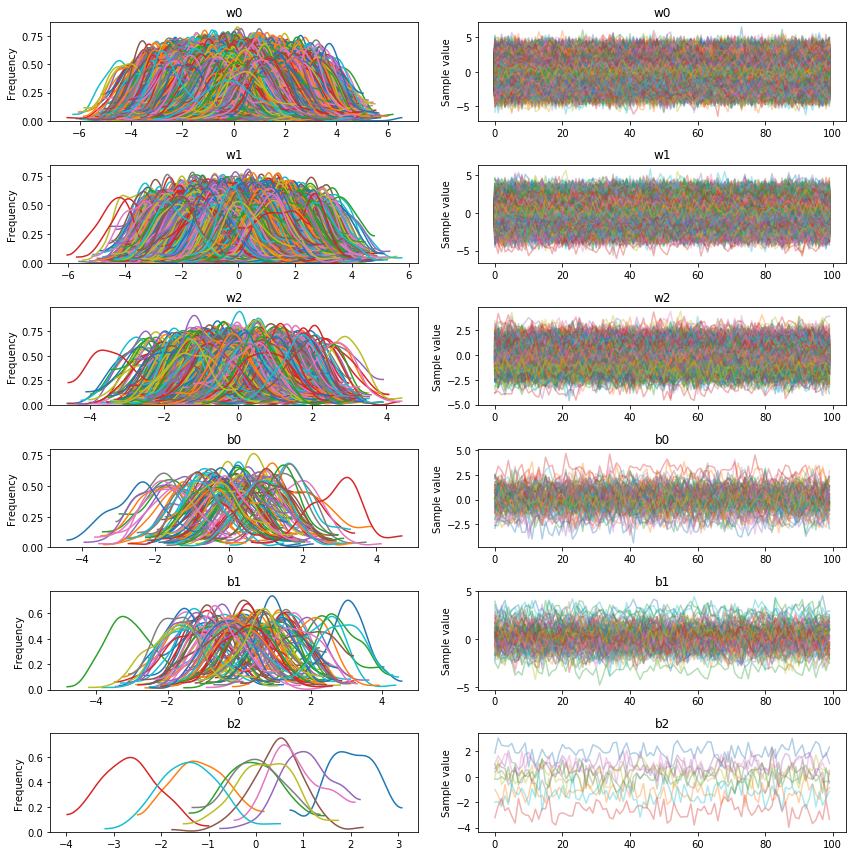

In [17]:
trace = approx.sample(draws=100)
pm.traceplot(trace)
plt.show()

----
Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

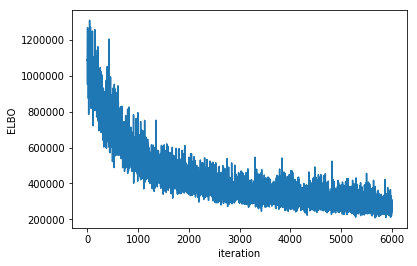

In [18]:
plt.plot(inference.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration")
plt.show()

-----
## 4) Prediction

In [20]:
x = T.matrix("X") # symbolic input
n = T.iscalar("n") # symbolic number of samples 
x.tag.test_value = np.empty_like(data_train[:10])
n.tag.test_value = 100

_sample_prob = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={nnt_input: x})
# compile the function
sample_prob = theano.function([x, n], _sample_prob)

In [34]:
vote = sample_prob(data_test, 500)
pred = vote.mean(0).argmax(axis=1)

In [39]:
print('Accuracy = {}%'.format((pred == label_test).mean() * 100))

Accuracy = 78.14999999999999%


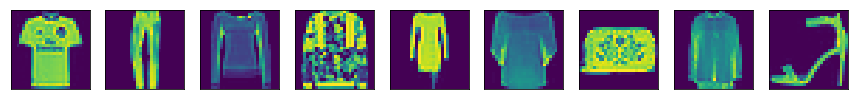

True Labels: ['t-shirt', 'trouser', 'pullover', 'pullover', 'dress,', 'pullover', 'bag', 'shirt', 'sandal']
Predictions: ['t-shirt', 'trouser', 'pullover', 'pullover', 'dress,', 'shirt', 'bag', 'shirt', 'sandal']


In [43]:
show_images(data_test[0:9])
print("True Labels:",get_text_labels(label_test[0:9]))
print("Predictions:",get_text_labels(pred[0:9]))

---
## 5）Comparision

Compare BNN with softmax regression

In [49]:
import sys
sys.path.append('..')
import utils

batch_size = 256
train_data, test_data = utils.load_data_fashion_mnist(batch_size)
def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [56]:
from mxnet import gluon

#define net
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(10))
net.initialize()
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss() #loss function
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1}) #optimization

In [58]:
from mxnet import ndarray as nd
from mxnet import autograd

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += utils.accuracy(output, label)

    test_acc = utils.evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))

Epoch 0. Loss: 0.424343, Train acc 0.854634, Test acc 0.853766
Epoch 1. Loss: 0.422444, Train acc 0.855135, Test acc 0.852464
Epoch 2. Loss: 0.421363, Train acc 0.855853, Test acc 0.856771
Epoch 3. Loss: 0.419741, Train acc 0.856020, Test acc 0.855168
Epoch 4. Loss: 0.418746, Train acc 0.855853, Test acc 0.856170


-----
## 6) Conclusion

We showed that Bayesian Neural Network is capable of solve classification problem. However, the speed of training is rather slow even we implement ADVI rather than MCMC, as well as the result did not out performed softmax regression.

Nevertheless, bridging Bayesian statistics with machine learning could probably be a direction to answer the basic question like why neural network have good performance.

-----
## 7) Appendix

Fashion-MNIST: https://www.kaggle.com/zalando-research/fashionmnist

[PYMC3](http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html): http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html